In [51]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy

SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 128
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 65536

DC_LR =3.0e-04
DC_EPOCH = 256

W_LR = 1.0e-04
W_EPOCH = 256
WClipLo = -0.01
WClipHi = 0.01
Lambda = 10

gpus = tf.config.experimental.list_physical_devices('GPU')

In [52]:
import glob
image_path = '/work/michael1017/lab14-2/img_align_celeba_png/'
images_path = sorted([x for x in glob.glob(image_path + '*.png')])
len(images_path)

202599

In [53]:
def map_load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = img / 255.0
    return img

In [54]:
dataset = tf.data.Dataset.from_tensor_slices(images_path)
dataset = dataset.map(map_load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dsTrain = dataset.shuffle(BUF).batch(BATCH_SIZE, drop_remainder=True)
dsTrain = dsTrain.prefetch(BUF)

def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [55]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [56]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(learning_rate=W_LR, beta_1=0.0, beta_2=0.9) # opt change to Adam 
optimizer_d = keras.optimizers.Adam(learning_rate=DC_LR, beta_1=0.0, beta_2=0.9)

@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)
    epslon = tf.random.normal([BATCH_SIZE, 1, 1, 1])
    
    with tf.GradientTape() as tpg:
        c0 = WG(z, training = True)
        c1_eps = epslon * c1 + (1 - epslon) * c0
        
        # Real Image
        z1 = WD(c1, training = True)
        # Fake Image
        z0 = WD(c0, training = True)
        
        with tf.GradientTape() as tape:  
            tape.watch(c1_eps)
            z2 = WD(c1_eps, training = True)
            
        grad = tape.gradient(z2, c1_eps)
        grad_norm =  tf.sqrt(tf.reduce_sum(tf.square(grad), axis = [1, 2, 3]))
        p = tf.reduce_mean(tf.square(grad_norm - 1.0)) * Lambda
        
        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1) + p

    gradient_g = tpg.gradient(lg, WG.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, WG.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(c1):
    z = tf.random.normal(BZ)
    epslon = tf.random.normal([BATCH_SIZE, 1, 1, 1])
    
    with tf.GradientTape() as tpd:
        c0 = WG(z, training = True)
        c1_eps = epslon * c1 + (1 - epslon) * c0

        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)
        
        with tf.GradientTape() as tape:
            tape.watch(c1_eps)
            z2 = WD(c1_eps, training = True)
        
        grad = tape.gradient(z2, c1_eps)
        grad_norm =  tf.sqrt(tf.reduce_sum(tf.square(grad), axis = [1, 2, 3]))
        p = tf.reduce_mean(tf.square(grad_norm - 1.0)) * Lambda
        
        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1) + p
        
    gradient_d = tpd.gradient(ld, WD.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, WD.trainable_variables))
    # clipping
    # for v in WD.trainable_variables: 
    #     v.assign(tf.clip_by_value(v, WClipLo, WClipHi))
    
    return lg, ld

In [57]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

In [58]:
checkpoint_path = "../../work/anyan_work/ckpts_lab14_2_lrchange"
ckpt = tf.train.Checkpoint(WG = WG,
                           WD = WD,
                           optimizer_g = optimizer_g,
                           optimizer_d = optimizer_d)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [59]:
start_epoch = 0
latest = ckpt_manager.latest_checkpoint
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print(latest)
    ckpt.restore(latest)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15


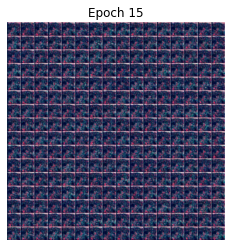

Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31


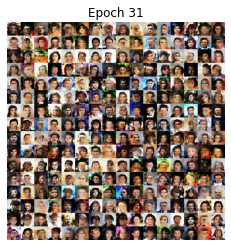

Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47


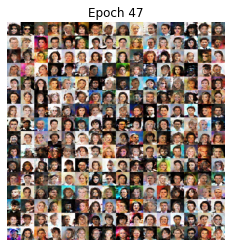

Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63


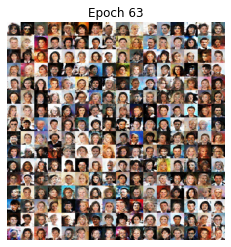

Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79


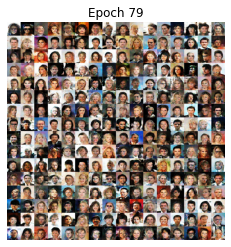

Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95


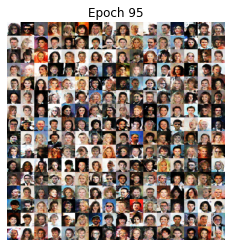

Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111


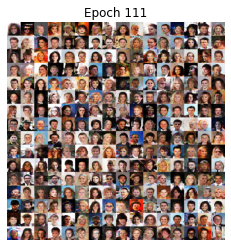

Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127


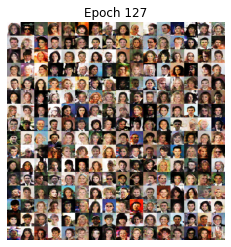

Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143


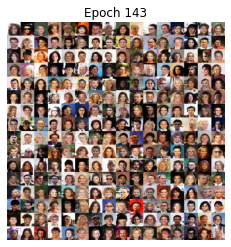

Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159


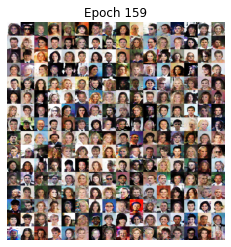

Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175


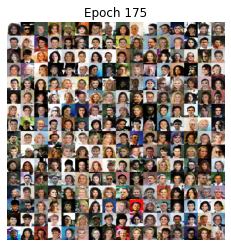

Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191


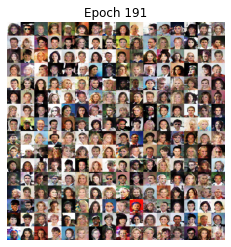

Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207


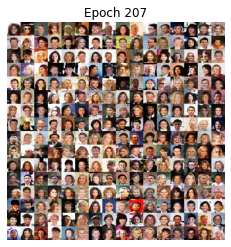

Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223


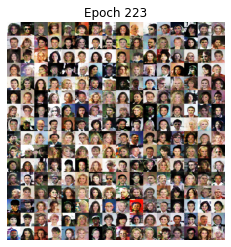

Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239


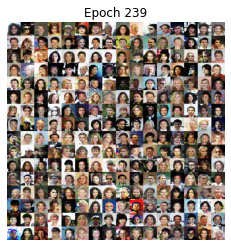

Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255


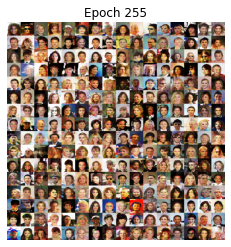

In [60]:
wlg = [None] * W_EPOCH #record loss of g for each epoch
wld = [None] * W_EPOCH #record loss of d for each epoch
wsp = [None] * W_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(images_path))
ctr = 0
for ep in range(W_EPOCH):
    print("Epoch: " + str(ep))
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "../../work/anyan_work/Lab14_2_imgs_lrchange/w_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 16 == 0:
        ckpt_manager.save()
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

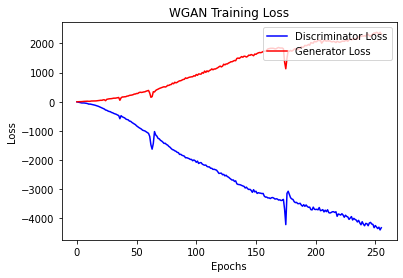

In [30]:
#first
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()

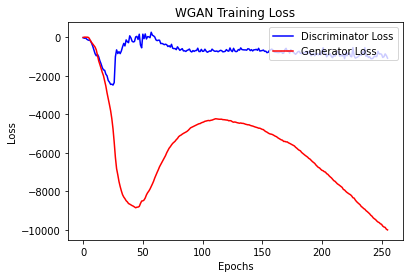

In [61]:
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()

In [63]:
utMakeGif(np.array(wsp), "../../work/anyan_work/Lab14_2_imgs_lrchange/gan.gif", duration = 2)

MoviePy - Building file ../../work/anyan_work/Lab14_2_imgs_lrchange/dcgan.gif with imageio.


In [68]:
from IPython.display import HTML
HTML('<img src="../../work/anyan_work/Lab14_2_imgs_lrchange/gan.gif" width="750" align="center">')

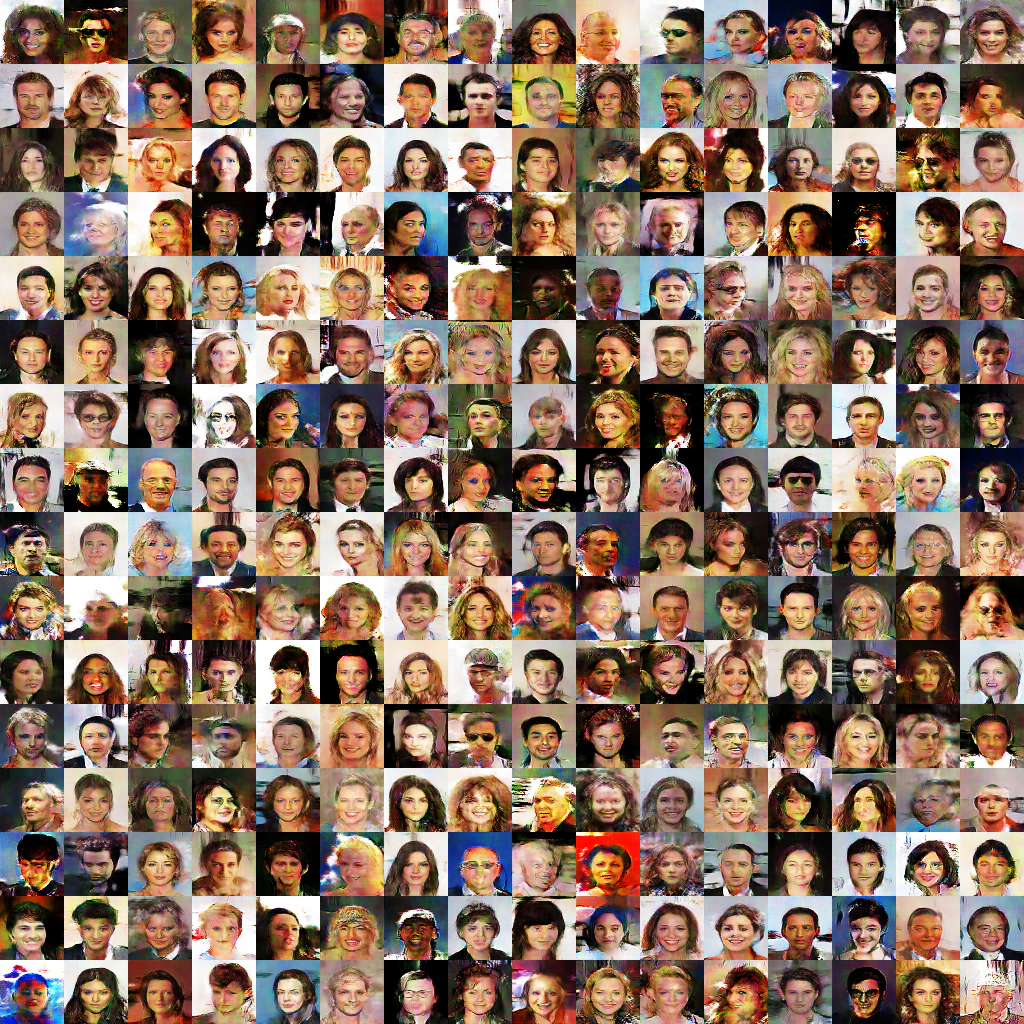

In [66]:
from PIL import Image
img = Image.open('../../work/anyan_work/Lab14_2_imgs_lrchange/w_0255.png', 'r')
img.show()

The default parameters could not improve after several epochs, resulting in similar images among the later hundreds of epochs.
I changed the batch size to 128, discriminator learning rate to 0.0003, and generator learning rate to 0.0001. In this situation, generator can slowly learn after the stronger the discriminator has grown. In the plot, we can observe that the generator loss decreases after about 125 epochs. I assume that the model can improve more if I set a larger number of epochs for training.
Codes were changed in WGTrain and WDTrain function.